In [79]:
import pandas as pd 
import glob
import os
from datetime import datetime
from datetime import timedelta

import numpy as np
import plotnine as pn
import patsy as pt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import hashlib



### Data manipulation: have multiple weekly files -- need to extract date from file name and add to dataframe


In [78]:
# extract date from filename
def extract_date(string):
    file_name = string.rsplit('/', 1)[-1]
    part_after_weekly = string.rsplit('_Weekly_', 1)[-1]
    date_part = part_after_weekly.rsplit('_', 1)[0]
    date_object = datetime.strptime(date_part, "%m-%d-%Y")
    return date_object


In [4]:
# loop through sales files and concat into single dataframe
path = r'csv/sales'
sales_files = glob.glob(os.path.join(path, '*.csv'))

sales_df = pd.DataFrame()

for file in sales_files:
    
    df = pd.read_csv(file, skiprows=1)
    df['Date'] = extract_date(file)
    
    sales_df = pd.concat([sales_df, df])

sales_df['next_week_date'] = sales_df['Date'] + timedelta(days=7)

In [5]:
# do the same with inventory files
path = r'csv/inventory'
inventory_files = glob.glob(os.path.join(path, '*.csv'))

inventory_df = pd.DataFrame()

for file in inventory_files:
    
    df = pd.read_csv(file, skiprows=1, low_memory=False)
    df['Date'] = extract_date(file)
    
    inventory_df = pd.concat([inventory_df, df])


In [9]:
# join inventory to sales
merged_df = pd.merge(sales_df, inventory_df, on=['ASIN', 'Date'], how='inner')


In [ ]:
# join on next week date to get next week's unhealthy units from inventory file
merged_df = pd.merge(merged_df, inventory_df, left_on=['ASIN', 'next_week_date'], right_on=['ASIN', 'Date'], how='inner')

In [37]:
# select relevant columns, clean up column names, and fill na's with 0
df = merged_df[['ASIN', 'Date_x', 'Ordered Units', 'Shipped Units', 'Net Received Units_x', 'Open Purchase Order Quantity_x', 'Aged 90+ Days Sellable Units_x', 'Sellable On Hand Units_x', 'Unsellable On Hand Units_x', 'Unhealthy Units_y']]
df.columns = df.columns.str.replace(' ', '_').str.replace('_x', '').str.replace('_y','').str.replace('+','')
df = df.dropna()
df = df.fillna(0)


In [38]:
# mask ASIN's (ASIN = product id number) so we can share this publicly
df['ASIN'] = df['ASIN'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

In [39]:
# save to csv for sharing
df.to_csv("unhealthy_units_project.csv", index=False)

In [40]:
# can repeat starting here
df = pd.read_csv('unhealthy_units_project.csv', low_memory=False)

In [41]:
# make data numeric
for item in df.columns:
    if item in ['ASIN', 'Date']:
        print(f'skip {item}')
    else:
        print(df[item].dtype)
        if df[item].dtype == 'object':
            df[item] = pd.to_numeric(df[item].str.replace(',',''))
        else:
            df[item] = pd.to_numeric(df[item])


skip ASIN
skip Date
int64
float64
object
object
object
object
float64
float64


In [42]:
df.dtypes

ASIN                             object
Date                             object
Ordered_Units                     int64
Shipped_Units                   float64
Net_Received_Units                int64
Open_Purchase_Order_Quantity      int64
Aged_90_Days_Sellable_Units       int64
Sellable_On_Hand_Units            int64
Unsellable_On_Hand_Units        float64
Unhealthy_Units                 float64
dtype: object

In [43]:
df.columns

Index(['ASIN', 'Date', 'Ordered_Units', 'Shipped_Units', 'Net_Received_Units',
       'Open_Purchase_Order_Quantity', 'Aged_90_Days_Sellable_Units',
       'Sellable_On_Hand_Units', 'Unsellable_On_Hand_Units',
       'Unhealthy_Units'],
      dtype='object')

In [44]:
y, X = pt.dmatrices("Unhealthy_Units ~ Ordered_Units + Shipped_Units + Net_Received_Units + Open_Purchase_Order_Quantity + Aged_90_Days_Sellable_Units + Sellable_On_Hand_Units + Unsellable_On_Hand_Units", df) 
fit = LinearRegression(fit_intercept = False).fit(X, y)

coeffs = fit.coef_[0]
coeffs

# strongest correlation seems to be to Unsellable_On_Hand_Units, but still not great

array([ 0.27179648, -0.01538689, -0.08213195,  0.01037358, -0.00137612,
        0.03267991, -0.0105319 ,  0.2117755 ])

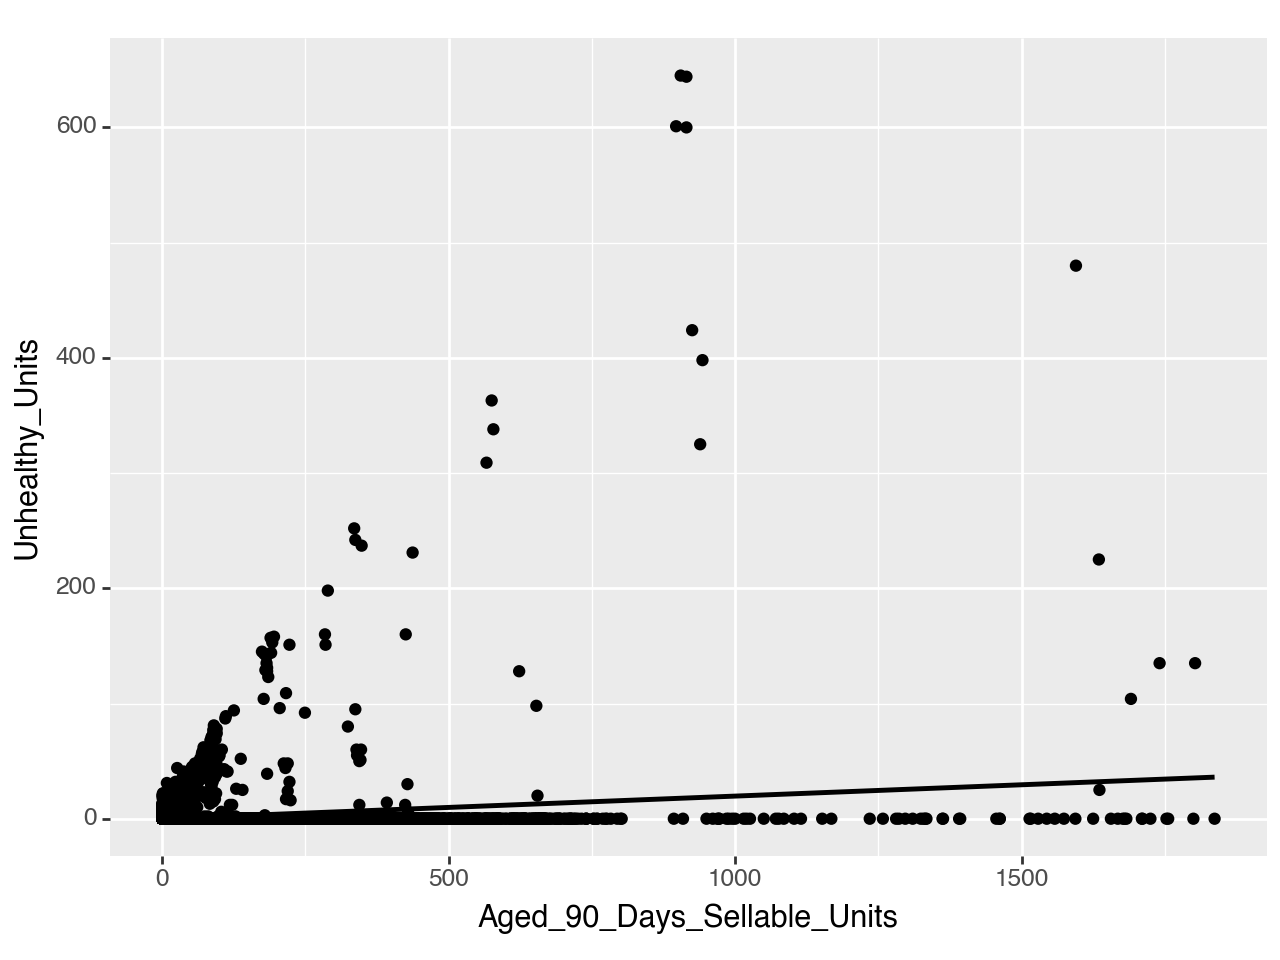

<Figure Size: (640 x 480)>

In [45]:
pn.ggplot(df, pn.aes("Aged_90_Days_Sellable_Units", "Unhealthy_Units")) + \
    pn.geom_point() + \
    pn.geom_smooth(method = "lm", se = False)

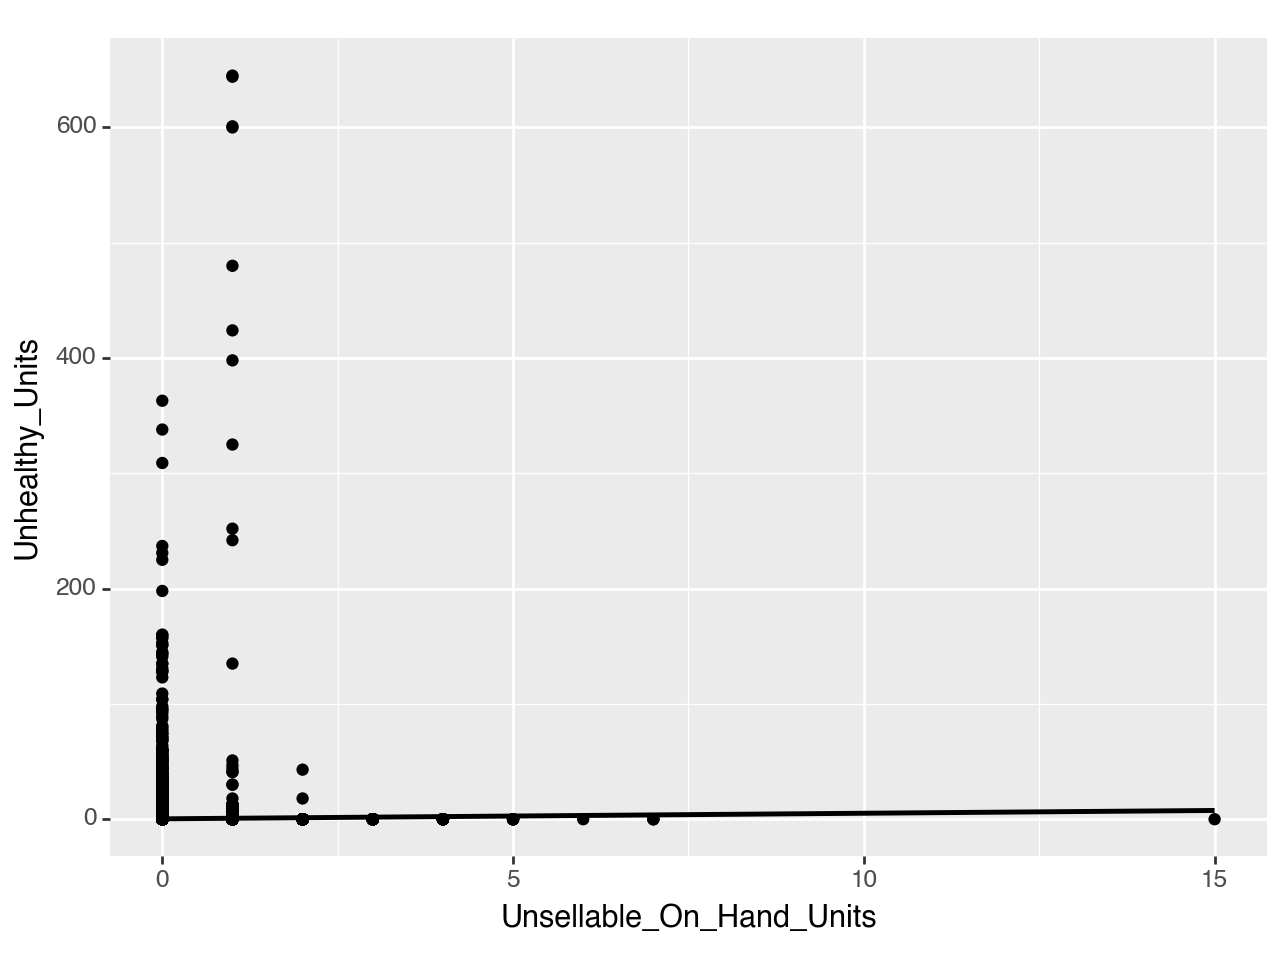

<Figure Size: (640 x 480)>

In [46]:
pn.ggplot(df, pn.aes("Unsellable_On_Hand_Units", "Unhealthy_Units")) + \
    pn.geom_point() + \
    pn.geom_smooth(method = "lm", se = False)

In [58]:
# make a prediction
df['estimated_unhealthy_units'] = coeffs[0] + coeffs[1] * df['Ordered_Units'] + coeffs[2] * df['Shipped_Units'] \
    + coeffs[3] * df['Net_Received_Units'] + coeffs[4] * df['Open_Purchase_Order_Quantity'] \
    + coeffs[5] * df['Aged_90_Days_Sellable_Units'] + coeffs[6] * df['Sellable_On_Hand_Units'] \
    + coeffs[7] * df['Unsellable_On_Hand_Units']


In [48]:
df.sort_values(by='Unhealthy_Units', ascending=False)

,ASIN,Date,Ordered_Units,Shipped_Units,Net_Received_Units,Open_Purchase_Order_Quantity,Aged_90_Days_Sellable_Units,Sellable_On_Hand_Units,Unsellable_On_Hand_Units,Unhealthy_Units,estimated_unhealthy_units
6738,c7cc804150aae7787c857ec9aaad2ed8bcfe90ca1de759...,2024-09-22,7,6.0,0,0,905,919,1.0,645.0,19.779575
18862,c7cc804150aae7787c857ec9aaad2ed8bcfe90ca1de759...,2024-09-15,10,11.0,0,0,915,923,1.0,644.0,19.607426
31829,c7cc804150aae7787c857ec9aaad2ed8bcfe90ca1de759...,2024-09-29,7,8.0,0,0,897,912,1.0,601.0,19.427595
70734,c7cc804150aae7787c857ec9aaad2ed8bcfe90ca1de759...,2024-10-06,4,2.0,0,0,915,915,1.0,600.0,20.523190
69347,315a4da1ffd81764bda3786a415a8fcce1acf4660921c7...,2024-10-06,46,41.0,0,0,1595,1595,1.0,480.0,31.734441
...,...,...,...,...,...,...,...,...,...,...,...
25494,cd4267f5aaf11427e51c2aa79b38c8c7f13c22b644d657...,2024-09-08,5,5.0,4,54,91,112,0.0,0.0,1.545685
25493,cd0a048f14e5cc45d848fa5bab78543af0b081c0b4db80...,2024-09-08,5,3.0,14,203,2,9,0.0,0.0,-0.215084
25492,1a4c6673cbd031f838ad1e13b5bb0374fa643e9c2dac2b...,2024-09-08,5,5.0,3,10,15,33,0.0,0.0,-0.055792
25491,d587eb18c5f58fd8fc2b024c5144a0a02b58540b1ede4e...,2024-09-08,5,5.0,3,19,24,66,1.0,0.0,0.090165


In [59]:
# calculate residuals and get mean squared error

# will never have negative unhealthy units, so convert negatives to zero first
df['estimated_unhealthy_units'] = df['estimated_unhealthy_units'].apply(lambda x: max(x,0)) 
df['residual'] = df['Unhealthy_Units'] - df['estimated_unhealthy_units']
round(np.mean(df['residual'] ** 2), 2)

47.72

In [22]:
# what if we remove some of the less significant variables?  will the mean squared error be lower?

In [50]:
df.columns

Index(['ASIN', 'Date', 'Ordered_Units', 'Shipped_Units', 'Net_Received_Units',
       'Open_Purchase_Order_Quantity', 'Aged_90_Days_Sellable_Units',
       'Sellable_On_Hand_Units', 'Unsellable_On_Hand_Units', 'Unhealthy_Units',
       'estimated_unhealthy_units', 'residual'],
      dtype='object')

In [51]:
# rerun of above to pull out the less significant variables
y, X = pt.dmatrices("Unhealthy_Units ~ Ordered_Units + Shipped_Units + Net_Received_Units + Open_Purchase_Order_Quantity + Aged_90_Days_Sellable_Units + Sellable_On_Hand_Units + Unsellable_On_Hand_Units", df) 
fit = LinearRegression(fit_intercept = False).fit(X, y)

coeffs = fit.coef_[0]
coeffs

# try using Shipped_Units, Aged_90_Days_Sellable_Units, and Unsellable_On_Hand_Units


array([ 0.27179648, -0.01538689, -0.08213195,  0.01037358, -0.00137612,
        0.03267991, -0.0105319 ,  0.2117755 ])

In [60]:
y2, X2 = pt.dmatrices("Unhealthy_Units ~ Shipped_Units + Aged_90_Days_Sellable_Units + Unsellable_On_Hand_Units", df) 
fit2 = LinearRegression(fit_intercept = False).fit(X2, y2)

coeffs2 = fit2.coef_[0]
coeffs2


array([ 0.20568427, -0.11462389,  0.02210435,  0.14491213])

In [62]:
# make another prediction 
df['estimated_unhealthy_units_2'] = coeffs2[0] + coeffs2[1] * df['Shipped_Units'] + coeffs2[2] * df['Aged_90_Days_Sellable_Units'] \
    + coeffs2[3] * df['Unsellable_On_Hand_Units'] 

In [64]:
df['estimated_unhealthy_units_2'] = df['estimated_unhealthy_units_2'].apply(lambda x: max(x,0)) 
df['residual_2'] = df['Unhealthy_Units'] - df['estimated_unhealthy_units_2']
round(np.mean(df['residual_2'] ** 2), 2)
# the previous value was 47.72
# that didn't seem to change things much

47.76

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75161 entries, 0 to 75160
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ASIN                          75161 non-null  object 
 1   Date                          75161 non-null  object 
 2   Ordered_Units                 75161 non-null  int64  
 3   Shipped_Units                 75161 non-null  float64
 4   Net_Received_Units            75161 non-null  int64  
 5   Open_Purchase_Order_Quantity  75161 non-null  int64  
 6   Aged_90_Days_Sellable_Units   75161 non-null  int64  
 7   Sellable_On_Hand_Units        75161 non-null  int64  
 8   Unsellable_On_Hand_Units      75161 non-null  float64
 9   Unhealthy_Units               75161 non-null  float64
 10  estimated_unhealthy_units     75161 non-null  float64
 11  residual                      75161 non-null  float64
 12  estimated_unhealthy_units_2   75161 non-null  float64
 13  r

In [66]:
# back up just in case
df_first_analysis = df

In [69]:
df = df.drop(['estimated_unhealthy_units', 'residual', 'estimated_unhealthy_units_2', 'residual_2'], axis=1)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75161 entries, 0 to 75160
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ASIN                          75161 non-null  object 
 1   Date                          75161 non-null  object 
 2   Ordered_Units                 75161 non-null  int64  
 3   Shipped_Units                 75161 non-null  float64
 4   Net_Received_Units            75161 non-null  int64  
 5   Open_Purchase_Order_Quantity  75161 non-null  int64  
 6   Aged_90_Days_Sellable_Units   75161 non-null  int64  
 7   Sellable_On_Hand_Units        75161 non-null  int64  
 8   Unsellable_On_Hand_Units      75161 non-null  float64
 9   Unhealthy_Units               75161 non-null  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 5.7+ MB


In [83]:
# wasn't able to get xgboost installed on my old mac
# after a fight, was able to get lightgbm installed
# modeled after analysis found here: 
# https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [92]:
# split data into x/y test/train

X = df.drop(columns=['Unhealthy_Units', 'ASIN', 'Date'])
y = df['Unhealthy_Units']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


In [93]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt', # gradient boosting decision tree
    'objective': 'regression',
    'num_leaves': 10,  # max leaves in one tree (?)
    'learning_rate': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1,
    'early_stopping_round':30 # if the model doesn't improve every 30 rounds, stop training
}
# load data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


In [111]:
# fit the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval) 
# make prediction
y_pred = model.predict(X_test)

In [109]:
# accuracy check
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

print('Down a bit from 47 earlier!')

MSE: 42.89
Down a bit from 47 earlier!


In [112]:
# making sure that my method of calculating mean sq. error earlier matches the function... indeed it does.
mse_first_analysis = mean_squared_error(df_first_analysis['Unhealthy_Units'], df_first_analysis['estimated_unhealthy_units_2'])
mse_first_analysis

47.75976711188358

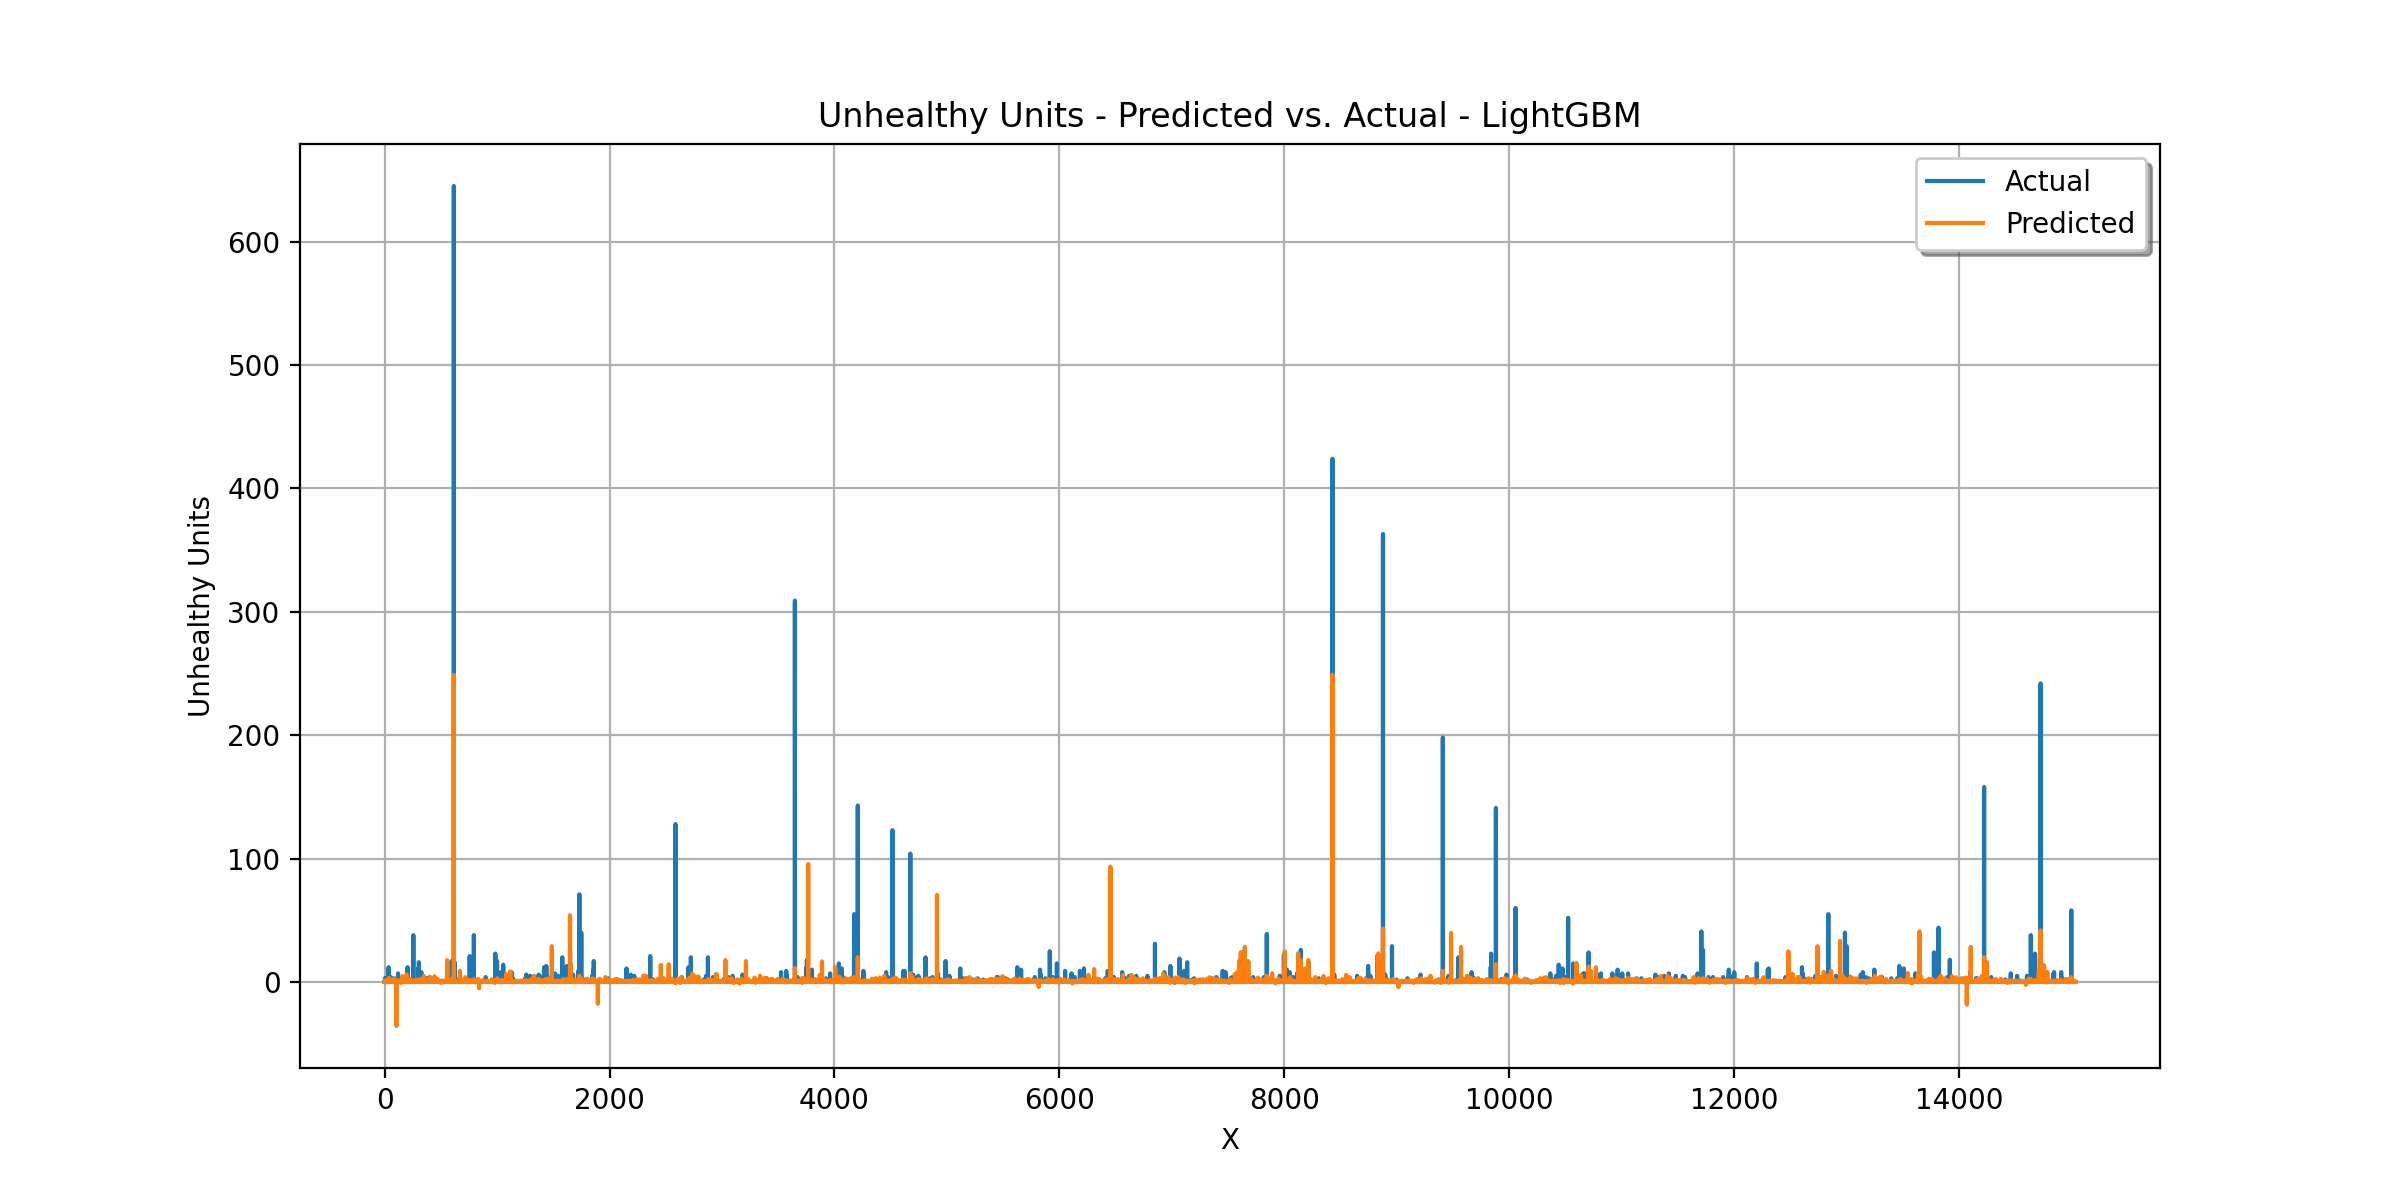

In [115]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_pred, label="Predicted")
plt.title("Unhealthy Units - Predicted vs. Actual - LightGBM")
plt.xlabel('X')
plt.ylabel('Unhealthy Units')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

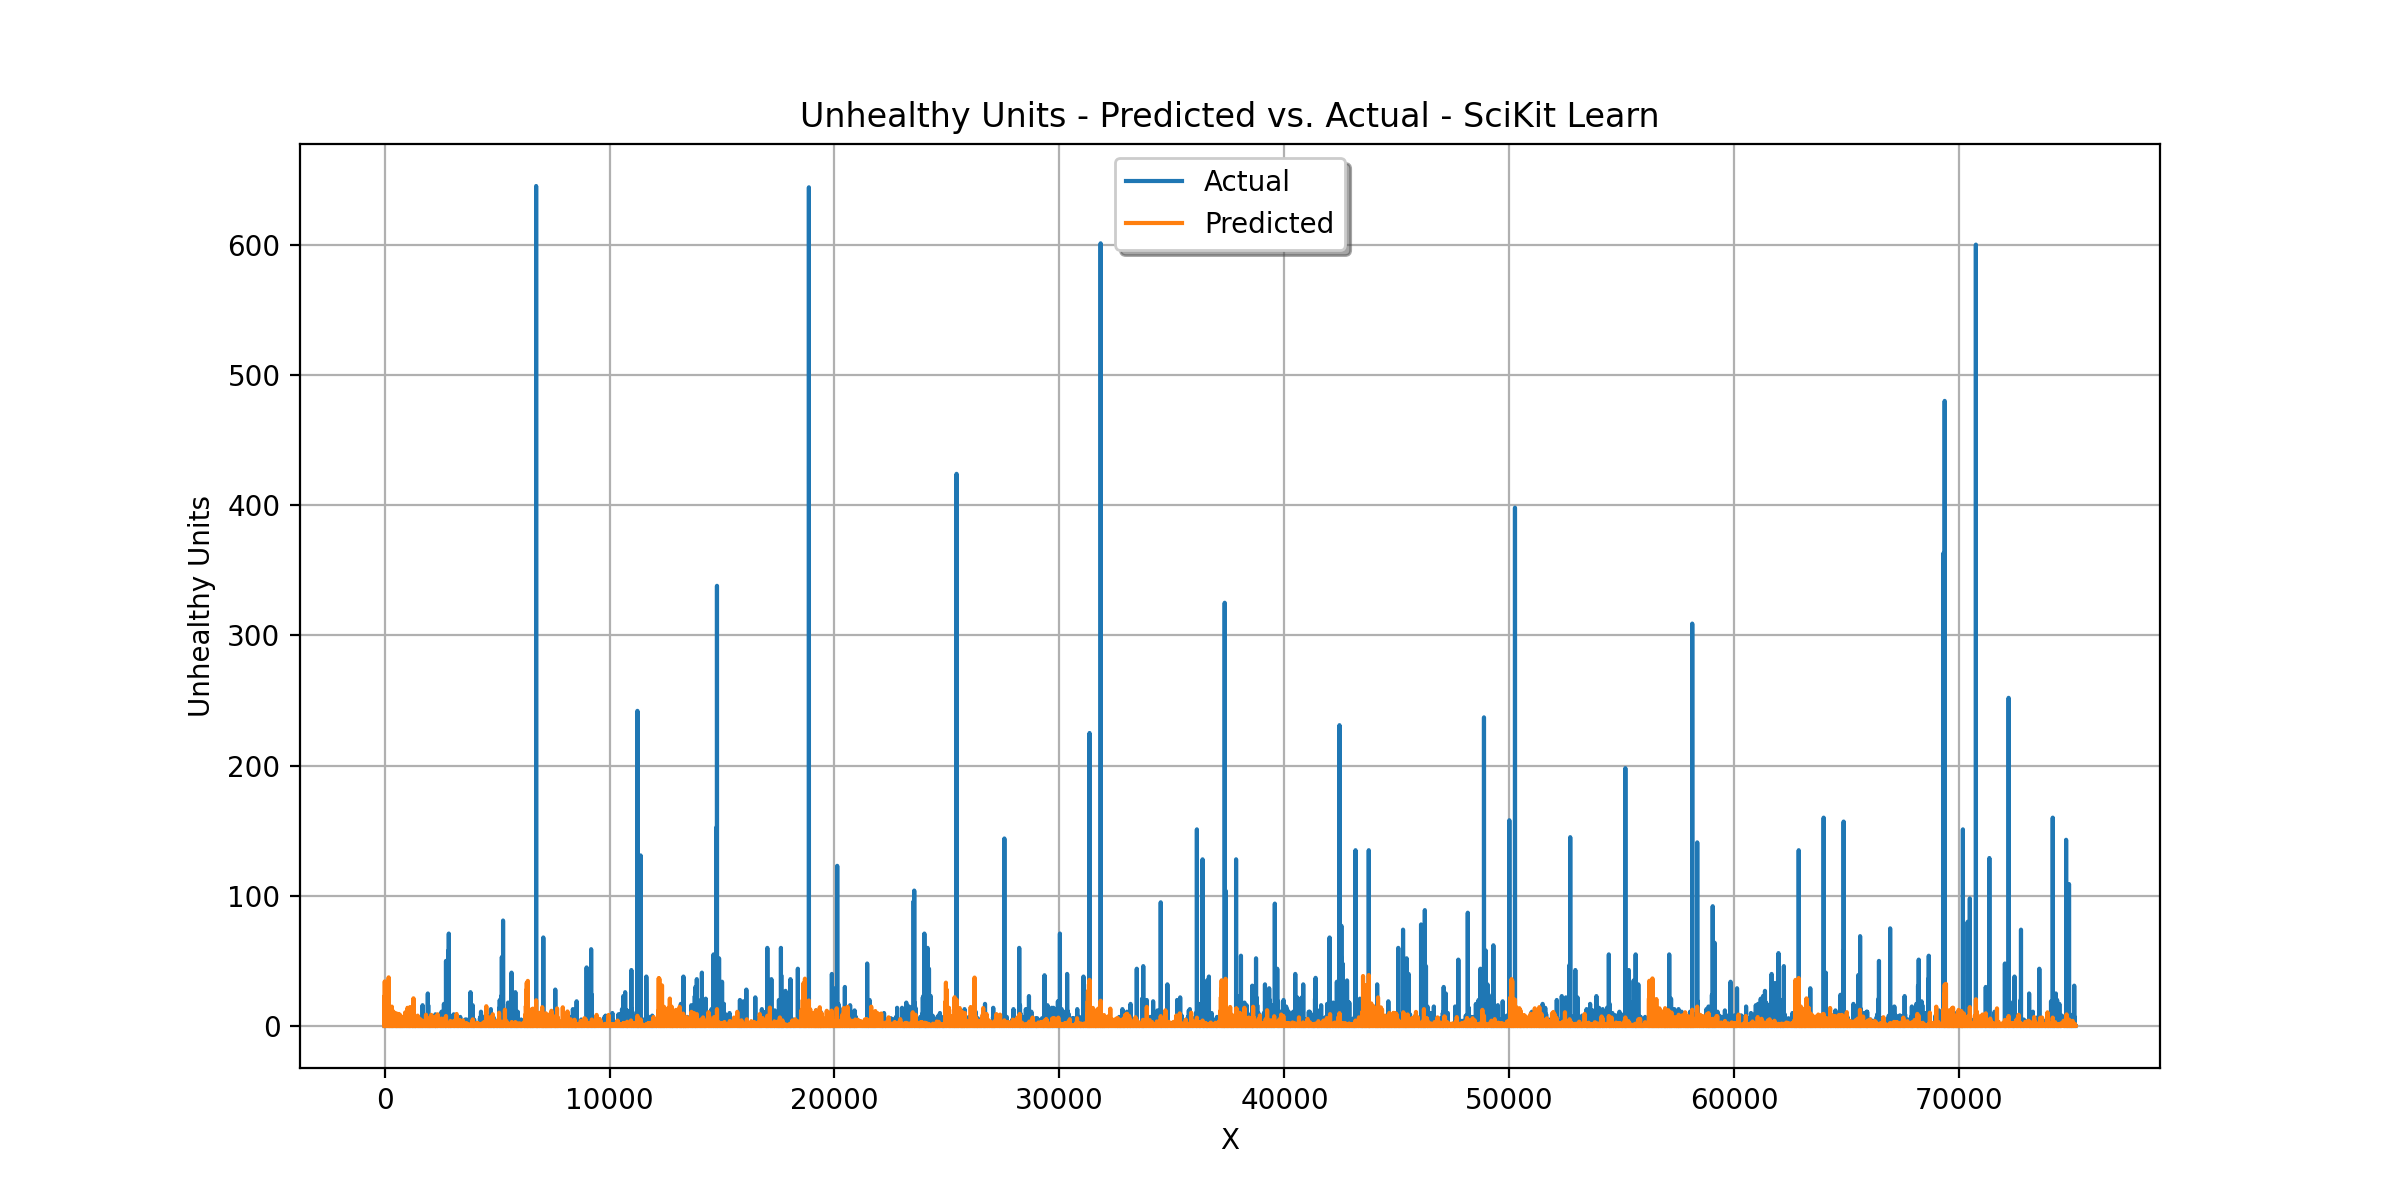

In [114]:
# do the same for the first analysis
y_test_fa = df_first_analysis['Unhealthy_Units']
y_pred_fa = df_first_analysis['estimated_unhealthy_units']
x_ax = range(len(y_test_fa))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test_fa, label="Actual")
plt.plot(x_ax, y_pred_fa, label="Predicted")
plt.title("Unhealthy Units - Predicted vs. Actual - SciKit Learn")
plt.xlabel('X')
plt.ylabel('Unhealthy Units')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Ideas for follow-up:
### - try a logistic regression with the y variable as: Unhealthy Units > 0 yes/no
### - do a simulation on cost savings / risk of undershipment if we started using this model actively
### - second one is difficult since we still don't know what Amazon will actually flag as Unhealthy